In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

# Doc-ID Reassignment

## 1. Data download

We download [RCV1 dataset](https://paperswithcode.com/dataset/rcv1), in particular we use tf-idf representation from [sklearn](https://scikit-learn.org/0.18/datasets/rcv1.html).

In [2]:
from model.rcv1 import RCV1Downloader

downloader = RCV1Downloader()
downloader

RCV1Downloader [File: /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz; Downloaded: True]

### Download

In [3]:
%%time

downloader.download()

CPU times: user 360 µs, sys: 87 µs, total: 447 µs
Wall time: 454 µs


## 2. Data Loading

### Create configurations

In [4]:
from model.solver import DataConfig

config = DataConfig(name="full", docs=-1, terms=-1, n_components=1000, n_cluster=150)
config

full [Docs: all; Terms: all; N-components: 1000; N-Clusters: 150]

### Loader instance

In [5]:
from model.rcv1 import RCV1Loader

loader = RCV1Loader()
loader

RCV1Loader [File: /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz]

### Load

In [6]:
collection = loader.load(n_docs=config.docs, n_terms=config.terms)

In [7]:
collection

DataCollection [Docs: 804414; Terms: 47219; Nonzero: 60915113]

## 3. Computing *d*-gap

### *d*-gap instance

Create and instance of DGapComputation for the collection.

In [8]:
from model.d_gap import DGapComputation

dgap = DGapComputation(collection=collection, data_name=config.name)
dgap

DGapComputation(full)[Docs: 804414; Terms: 47219; Computed: False]

### Compute *d*-gap statistics

We compute *d*-gap in the given collection.

In [9]:
%%time

dgap.compute_d_gaps()

CPU times: user 11.2 ms, sys: 879 µs, total: 12.1 ms
Wall time: 22 ms


In [10]:
avg_d_gaps = dgap.avg_d_gap_pterm
avg_d_gaps

array([10, 11, 11, ..., 88, 72, 80])

### Average *d*-gap per term plot

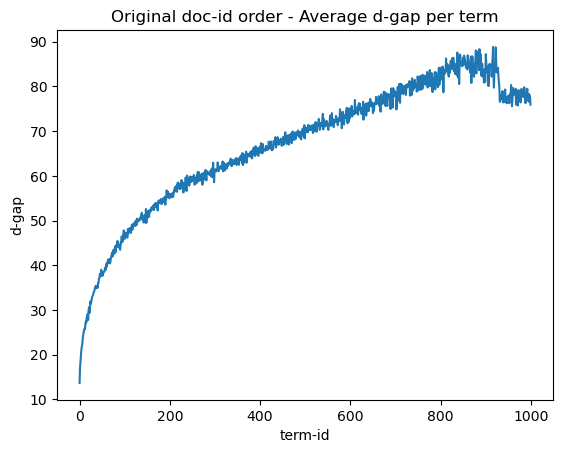

In [11]:
dgap.plot_avg_d_gap()

### Average *d*-gap

In [12]:
dgap.avg_d_gap

67.08168322073742

### Save statistics

We save statistics with in the directory with the specific configuration name: it will be no more necessary a second computation for further analysis.

In [13]:
dgap.save_d_gaps()

## 5. Clustering

### Compute number of clusters

We compute the number of cluster to find using a function specified in the configuration.

In [14]:
n_cluster = config.n_cluster
n_cluster

150

### Create K-Means instance

In [15]:
from model.clustering import KMeansClustering

kmeans = KMeansClustering(collection=collection, data_name=config.name, k=n_cluster)

In [16]:
kmeans

KMeansClustering(full)[Items: 804414; k: 150; Labeling computed: False]

In [17]:
%%time

kmeans.fit()

CPU times: user 212 ms, sys: 15.7 ms, total: 227 ms
Wall time: 237 ms


In [18]:
labeling = kmeans.labeling

labeling

array([99, 81, 11, ..., 44,  5, 22])

In [19]:
kmeans.save_labeling()

## 6. Cluster split

### Get CollectionCluster instance

We split data in cluster using the labeling.

In [20]:
collection_clusters = kmeans.clusters

In [21]:
collection_clusters

RCV1Clusters(full)[Data: 804414, Clusters: 150, Mean-per-Cluster: 5362.760; centroids computed: False]

### Compute centroids

In [22]:
%%time

collection_clusters.compute_centroids()

CPU times: user 3.17 ms, sys: 81.2 ms, total: 84.4 ms
Wall time: 132 ms


In [23]:
centroids = collection_clusters.centroids

In [24]:
collection_clusters.save_centroids()

## 7. doc-*ID* reassignment

In [25]:
from model.reassignment import DocIdReassignmentComputation

reassignment_computation = DocIdReassignmentComputation(
    cluster=collection_clusters,
    data_name=config.name
)

reassignment_computation

DocIdReassignmentComputation(full)[]

In [32]:
cluster = collection_clusters[0]
cluster

<10256x47219 sparse matrix of type '<class 'numpy.float64'>'
	with 285116 stored elements in Compressed Sparse Row format>

In [33]:
from scipy.sparse import csr_matrix

centroid = csr_matrix(collection_clusters.centroids[0])
centroid

<1x47219 sparse matrix of type '<class 'numpy.float64'>'
	with 7928 stored elements in Compressed Sparse Row format>

In [35]:
import sklearn

sklearn.metrics.pairwise.pairwise_distances(centroid, cluster)

array([[0.98260076, 0.934599  , 0.98553406, ..., 0.88883224, 0.90577445,
        0.9590341 ]])

In [28]:
reassignment_computation.solve()

  0%|          | 0/150 [00:00<?, ?it/s]

ValueError: Input vector should be 1-D.

In [31]:
reassignment_computation.centroids_order

array([  2, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138,
       137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125,
       124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112,
       111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100,  99,
        98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,  86,
        85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,
        72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,
        59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  49,  48,  47,
        46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,
        33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,  21,
        20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,   8,
         7,   6,   5,   4,   3,   1,   0])

In [32]:
reassignment_computation.cluster_order

{0: array([ 15, 131, 181, 188, 279, 278, 174, 172, 141,  57,   9,  16, 170,
          8,   7, 276, 182, 115, 268, 105, 130, 103, 168, 270,  44,  43,
         90,  88, 184, 187, 116, 104, 132, 133, 156,  93, 208,  98, 167,
         92, 262,  91, 261, 229, 114, 102, 185, 274, 228, 179, 163, 166,
         29, 176, 183, 215, 159,  13, 173,  38, 272,  37, 277, 164,  51,
        259, 165, 123, 162, 186, 157, 197, 249, 281, 196,   4, 280, 180,
        232, 224,  56, 160, 195,  76,  26, 144,  73, 255, 211, 171, 257,
        118, 161,   6, 119,  82,  59, 169, 117, 121, 145, 203, 230, 231,
         23, 269,  21, 143, 210,  62, 136, 244, 129, 199,  60,  65, 209,
        198,   5, 126, 128,   3, 246, 248, 178, 140, 135, 223,   2, 134,
         81, 227,  34, 139, 245,  33, 252, 142, 107, 148, 271, 127, 101,
         85,  97,  20,  42, 149, 137, 147, 125, 155, 124,  36,  89, 122,
         19,  35, 100,   1, 120, 242,  41,  17, 264, 216, 177, 265,  32,
        263, 273, 219, 236,  99,  80,  31, 266, 

In [33]:
reassignment_computation.save_order()

INFO: Saving centroids and cluster order to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/reassignment_order.json 


In [34]:
from model.reassignment import DocIdReassignment

docs_reassignment = DocIdReassignment(
    collection=collection,
    labeling=labeling,
    centroids_order=reassignment_computation.centroids_order,
    clusters_order=reassignment_computation.cluster_order,
    data_name=config.name
)

docs_reassignment

DocIdReassignment[Items: 50000]

In [35]:
collection_reass = docs_reassignment.reassign_doc_id()

collection_reass

DataCollection [Docs: 50000; Terms: 14980; Nonzero: 1314210]

In [36]:
from model.d_gap import DGapComputationReassigned

dgap_reass = DGapComputationReassigned(collection=collection_reass, data_name=config.name)
dgap_reass

DGapComputation(tiny)[Docs: 50000; Terms: 14980; Computed: False]

In [37]:
dgap_reass.compute_d_gaps()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/avg_d_gap_reassigned.json. 
INFO: Computing average d-gap per term. 


100%|██████████| 50000/50000 [00:02<00:00, 16933.71it/s]


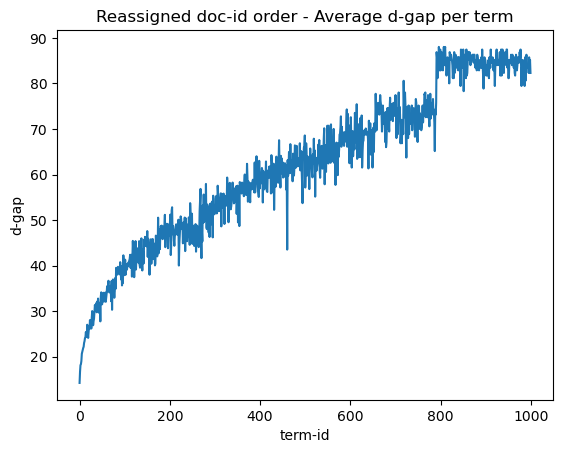

In [38]:
dgap_reass.plot_avg_d_gap()

In [39]:
dgap_reass.save_d_gaps()

INFO: Saving average d-gap per term to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/avg_d_gap_reassigned.json. 


## 8. Inference

In [43]:
from model.d_gap import DGapInference

inference = DGapInference(d_gap_original=dgap, d_gap_reassigned=dgap_reass, data_name=config.name)
inference

INFO: Average d-gaps already computed. Use `gaps_stats` to retrieve them. 
INFO: Average d-gaps already computed. Use `gaps_stats` to retrieve them. 


DGapInference[Terms: 14980]

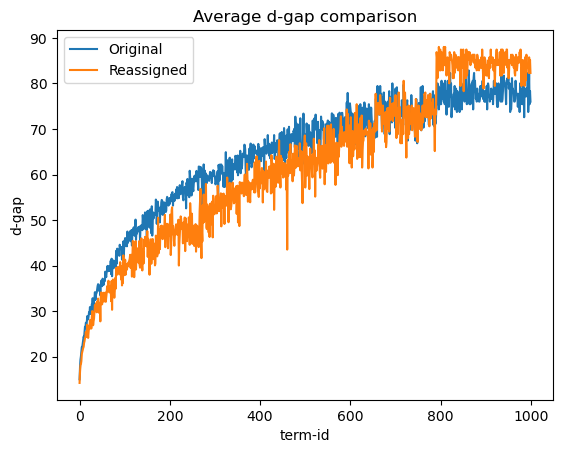

In [44]:
inference.plot_avg_d_gap()

In [46]:
inference.avg_compression

8.6481656017983